# Digital Musicology (DH-401)
## Assignment 1: Discovering meter
Group 6
- Mickaël Achkar
- Yichen Wang
- Yinghui Jiang

Rough outline
## 0. Data preparation
## 1. From musical score to metrical weights
## 2. From metrical weights to periodicities
## 3. From periodicities to time signature
## 4. Accuracy of classification

#TODO:
- consider grace notes as normal notes (replace 'duration' with 'nominal_duration',
because 'duration' is empty for them) -> check before/after impact to classification
- we also need to sum up durations of tied notes based on piece and staff and voice
- use appropriate method to extract frequencies/periodicities
- use appropriate method to infer time signature
- create simple classification accuracy measure with Ground Truth

In [1]:
import ms3
import pandas as pd
import numpy as np
import math
import fractions
import matplotlib.pyplot as plt
from scipy.fftpack import rfft, rfftfreq
from scipy.signal import find_peaks
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm

## 0. Data preparation

In [2]:
# This is the time unit of 'global_onset' used in the dataset
time_unit = 1/4

meter_dataset = pd.read_csv('DM2022 - Assignment 1 [Dataset].csv', index_col = 0, converters = {'global_onset':fractions.Fraction, 'duration': fractions.Fraction})
df = meter_dataset[['piece','timesig','global_onset', 'staff', 'voice', 'duration', 'nominal_duration', 'tied', 'gracenote']]

# Ignore gracenotes for now
df = df[df['gracenote'].isna()]

## 1. From musical score to metrical weights

Smallest note length in dataset: 1/32


,piece,timesig,global_onset,staff,voice,duration,nominal_duration,tied,gracenote
269850,K309-1,4/4,0,1,1,1/2,1/2,NaN,NaN
269852,K309-1,4/4,2,1,1,1/2,1/2,NaN,NaN
269854,K309-1,4/4,4,1,1,3/8,1/4,NaN,NaN
269856,K309-1,4/4,11/2,1,1,1/16,1/16,NaN,NaN
269858,K309-1,4/4,23/4,1,1,1/16,1/16,NaN,NaN
...,...,...,...,...,...,...,...,...,...
272217,K309-1,4/4,617,1,1,1/4,1/4,NaN,NaN
272218,K309-1,4/4,617,1,1,1/4,1/4,NaN,NaN
272221,K309-1,4/4,618,1,1,1/4,1/4,NaN,NaN
272222,K309-1,4/4,618,1,1,1/4,1/4,NaN,NaN


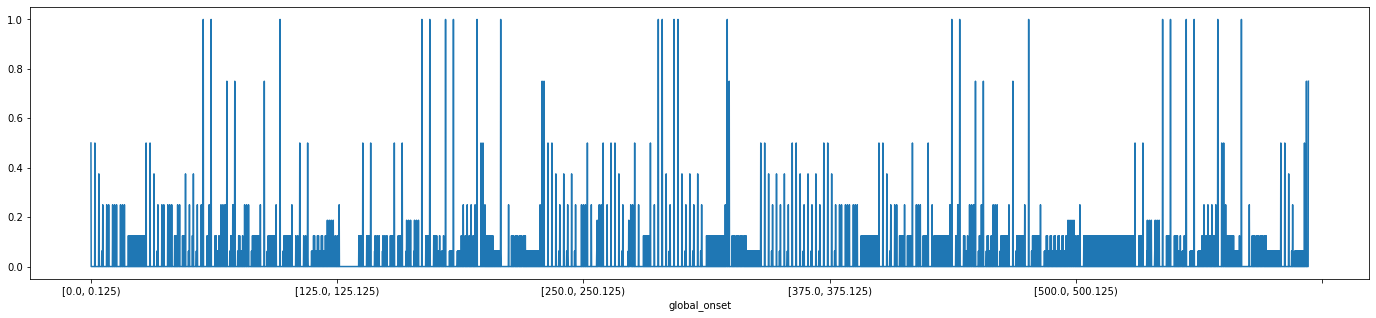

In [3]:
# Select one piece and staff (time signature may change per staff)
one_piece_staff = df[(df['piece'] == 'K309-1') & (df['staff'] == 1)]

# To fine-tune sampling, get minimum note duration among all notes in the piece/staff
min_note = float(one_piece_staff['duration'].min())
print("Smallest note length in dataset:", fractions.Fraction(min_note))

sampling_period = min_note/time_unit
total_piece_duration = one_piece_staff['global_onset'].max()

# Partition the global_onsets in bins
bins = np.arange(0, (total_piece_duration+sampling_period+1e-10), sampling_period)
binned_onsets = pd.cut(one_piece_staff['global_onset'], bins, right = False)

# Compute the sum of durations of all events with onsets in each bin
summed_durations = one_piece_staff.groupby(binned_onsets)['duration'].sum().apply(float)
summed_durations.plot(figsize=(24,5));

one_piece_staff

In [4]:
%%time

# For all pieces and staves (This operation takes around 2-3 minutes on our computer)

# Create dictionaries of total piece durations and smallest notes in each piece/staff
total_piece_durations_df = df.groupby(['piece','staff'])['global_onset'].max().apply(float)
minimum_note_durations_df = df.groupby(['piece','staff'])['duration'].min().apply(float)
total_piece_durations = total_piece_durations_df.to_dict()
minimum_note_durations = minimum_note_durations_df.to_dict()

summed_durations = {}
for key,value in total_piece_durations.items():
    piece_staff = df[(df['piece'] == key[0]) & (df['staff'] == key[1])]

    min_note = minimum_note_durations[key]
    sampling_period = min_note/time_unit

    bins = np.arange(0, (value+sampling_period+1e-10), sampling_period)
    binned_onsets = pd.cut(piece_staff['global_onset'], bins, right = False)
    summed_durations[key] = piece_staff.groupby(binned_onsets)['duration'].sum().apply(float)

CPU times: user 1min 26s, sys: 1.15 s, total: 1min 27s
Wall time: 1min 32s


Metrical weights of Piece: n09op59-3_03, Staff: 1, Time Signature: 3/4


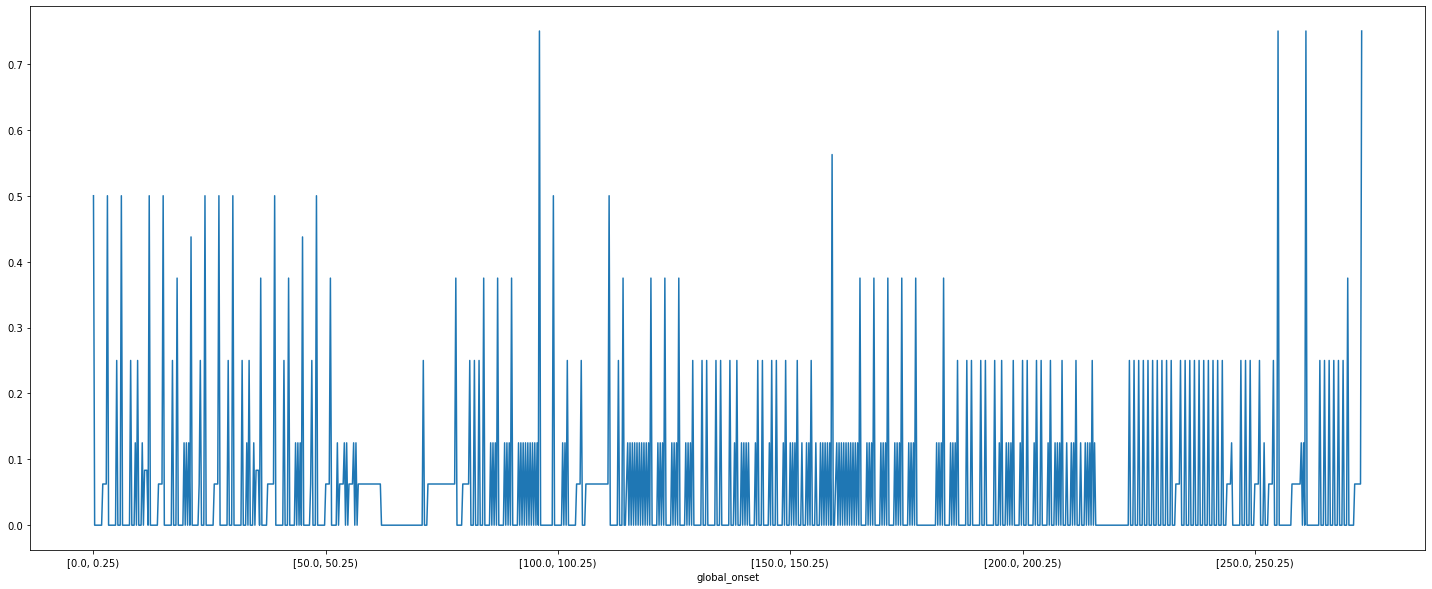

In [15]:
# Now we can plot the metrical weights of a random piece + staff
random_piece_staff = df[['piece', 'staff']].sample(n=1).to_records(index=False)
key = tuple(random_piece_staff[0])

# Get timesignature for reference
timesig = df[(df['piece'] == key[0]) & (df['staff'] == key[1])]['timesig'].sample(n=1).item()

print("Metrical weights of Piece: {piece}, Staff: {staff}, Time Signature: {timesig}".format(piece = key[0], staff = key[1], timesig=timesig))

# Plot metrical weights
summed_durations[key].plot(figsize=(25,10));


## 2. From metrical weights to periodicities

Periodicity analysis of Piece: n09op59-3_03, Staff: 1, Time Signature: 3/4


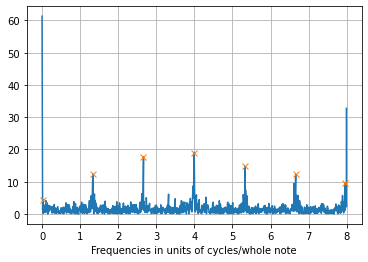

   frequency (cycles/whole note) period (1/f)  amplitude
3                       3.996340          1/4  19.046523
2                       2.664227          3/8  17.743715
4                       5.328454         3/16  14.744710
1                       1.332113          3/4  12.370820
5                       6.660567         3/20  12.264440
6                       7.963403          1/8   9.703555
0                       0.029277      1093/32   4.391471


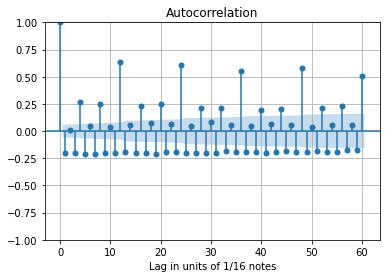

    lag (whole notes)  autocorrelation
12                3/4         0.635275
24                3/2         0.610124
48                  3         0.584006
36                9/4         0.549076
60               15/4         0.502340
72                9/2         0.481865
96                  6         0.471825
312              39/2         0.406614
84               21/4         0.406115
288                18         0.405029
108              27/4         0.401943
120              15/2         0.398146
336                21         0.397812
144                 9         0.395573
132              33/4         0.392079
324              81/4         0.388682
300              75/4         0.388217
156              39/4         0.375059
276              69/4         0.373777
264              33/2         0.371850


In [17]:
print("Periodicity analysis of Piece: {piece}, Staff: {staff}, Time Signature: {timesig}".format(piece = key[0], staff = key[1], timesig=timesig))

x = summed_durations[key].index.tolist()
y = summed_durations[key].tolist()

# Number of sample points
N = len(x)
# Sample spacing (in units of time_unit)
T = x[1].left

######################################################
# Right Fast Fourier Transform
yf = rfft(y)
xf = rfftfreq(N, T)
# Convert frequencies to units of cycles/whole note
xf = xf/time_unit
# Convert Fourier output to real-valued amplitudes
amplitudes = np.abs(yf)

# Find significant peaks (using min distance between neighbouring peaks)
peaks, _ = find_peaks(amplitudes, distance=N*.1)

# Plot Fourier Transform
plt.plot(xf, amplitudes)
plt.plot(xf[peaks], amplitudes[peaks], "x")
plt.xlabel('Frequencies in units of cycles/whole note')
plt.grid()
plt.show()

# Get top frequencies (and periods)
fourier_peaks = np.array(tuple(zip(xf[peaks], 1/xf[peaks], amplitudes[peaks])))
# Create DataFrame
fourier_df = pd.DataFrame(fourier_peaks, columns = ['frequency (cycles/whole note)', 'period (1/f)', 'amplitude'])
# Convert period (1/f) to Fractions
fourier_df['period (1/f)'] = [fractions.Fraction(period).limit_denominator(100) for period in fourier_df['period (1/f)']]
# Sort in descending order
fourier_df_sorted = fourier_df.sort_values(by='amplitude', ascending=False)
print(fourier_df_sorted)

######################################################
# Plot autocorrelations with respect to first few lags
nlags = int(15*1/T) # First few lags
plot_acf(y, lags=nlags)
plt.xlabel('Lag in units of {} notes'.format(fractions.Fraction(T*time_unit).limit_denominator(100)))
plt.grid()
plt.show()

# Get top 20 autocorrelations
autocorr = sm.tsa.acf(y, nlags=len(y))
# Convert lags in units of whole notes
converted_lags = range(len(autocorr))*(T*time_unit)
# Create DataFrame
autocorr_df = pd.DataFrame(tuple(zip(converted_lags, autocorr)), columns = ['lag (whole notes)','autocorrelation'])
# Convert lags to Fractions
autocorr_df['lag (whole notes)'] = [fractions.Fraction(onset).limit_denominator(100) for onset in autocorr_df['lag (whole notes)']]
# Sort in descending order
autocorr_df_sorted = autocorr_df.sort_values(ascending=False, by='autocorrelation').drop(0).head(20)
print(autocorr_df_sorted)
